### Prolongements sur les accidents innaboutis faute de données

In [33]:
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import cluster

In [16]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
# Il y a un problème avec les latitudes et les longitudes nulles et les quelques erreurs

C:\Users\Vinciane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
accident_velo_idf_meteo = accident_velo_idf[['identifiant accident','date','mois', 'jour', 'heure', 'departement','luminosite', 'conditions atmosperiques', 'etat surface', 'sexe', 'age', 'gravite accident', 'commune', ]]
accident_velo_idf_meteo

,identifiant accident,date,mois,jour,heure,departement,luminosite,conditions atmosperiques,etat surface,sexe,age,gravite accident,commune
58,200500001606,2005-01-13,01 - janvier,3 - jeudi,11.0,78,Plein jour,Normale,normale,M,61-62,2 - Blessé hospitalisé,78230
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,Plein jour,Normale,normale,M,58-59,0 - Indemne,95042
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17.0,75,Nuit avec éclairage public allumé,Normale,normale,M,36-37,1 - Blessé léger,75001
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9.0,75,Plein jour,Normale,normale,M,26-27,0 - Indemne,75005
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17.0,75,Nuit avec éclairage public allumé,Normale,normale,M,31-32,0 - Indemne,75019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,201800050291,2018-07-10,07 - juillet,1 - mardi,9.0,75,Plein jour,Normale,normale,F,58-59,2 - Blessé hospitalisé,75101
65532,201800050337,2018-11-17,11 - novembre,5 - samedi,12.0,75,Plein jour,Normale,normale,M,59-60,1 - Blessé léger,75101
65533,201800050355,2018-02-01,02 - février,3 - jeudi,15.0,75,Plein jour,Temps couvert,mouillée,M,31-32,1 - Blessé léger,75102
65534,201800050359,2018-02-12,02 - février,0 - lundi,9.0,75,Plein jour,Normale,normale,F,29-30,1 - Blessé léger,75101


Faute de donnée pour étudier la corrélation entre les conditions météorologiques et les accidents, nous avons tout de même essayé de faire une moyenne du nombre d'accidents quotidiens en utilisant les trois données disponibles sur internet indiquant le nombre de cyclistes quotidiens en Ile de France :  https://www.iau-idf.fr/fileadmin/NewEtudes/Etude_1120/40ansEvolutionVelo.pdf

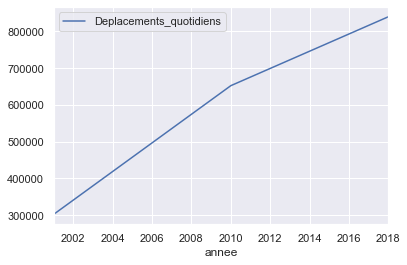

In [18]:
annee =[2001, 2010, 2018] 
Deplacements_quotidiens= [302219, 652496,840000] #Nombre de déplacements quotidiens mesurés en moyenne en Ile-de-France
d = {'annee': annee, 'Deplacements_quotidiens': Deplacements_quotidiens}
df = pd.DataFrame(data=d)
df.plot('annee')
#Rajouter titre

In [19]:
from datetime import date
l = []
for i in range (2005,2018):
    d0 = date(i, 1, 1)
    d1 = date(i+1,12, 31)
    delta = d1 - d0
    nb_deplacement_an = delta.days*np.interp(i, annee, Deplacements_quotidiens)
    l.append(nb_deplacement_an)
nb_deplacement_total = sum(l) #Nombre  total de trajet parcourus
nb_deplacement_total

6240583002.666666

In [20]:
#Nombre d'accident par rapport au total des déplacements entre 2005 et 2018
#Fréquence à laquelle se produit un accident
len(accident_velo_idf)/nb_deplacement_total 


2.8107950799636104e-06

Ce résultat nous a cependant semblé trop approximatif pour être retenu dans le notebook final. De plus, il n'allait pas trop dans notre optique qui était de dire au cycliste de faire le plus attention possible lors de son trajet. En effet, ce résultat laisse entendre que la probabilité d'avoir un acicdent est très faible.

Réflexion sur les clusters, autre méthode :


# Réfléxion sur la réalisation des clusters : première méthode envisagée, celle du K-means

In [34]:
#On transforme les coordonnées latitudes/longitudes en coordonnées lisibles par géopandas
gdf = gpd.GeoDataFrame(accident_velo_idf, geometry=gpd.points_from_xy(accident_velo_idf.lon, accident_velo_idf.lat))
#Elimination des valeurs manquantes et aberrantes (situées hors Ile-de-France)
gdf = gdf.cx[1.44:3.57,48.12:49.2]
gdf.head(5)  #On remarque qu'il nous reste 3462 accidents sur les 17541

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,...,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules,geometry
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,95042,49.064,2.328,non,...,NaN,NaN,NaN,Arrière,Sans changement de direction,200500001930B02,Cyclomoteur <50cm3,"Même sens, même file",1.0,POINT (2.32800 49.06400)
1142,200500024289,2005-04-10,04 - avril,6 - dimanche,9.0,78,78497,48.697,1.771,non,...,NaN,NaN,Véhicule,Avant,Déporté à gauche,200500024289A01,NaN,NaN,NaN,POINT (1.77100 48.69700)
1143,200500024300,2005-04-24,04 - avril,6 - dimanche,18.0,78,78062,48.850,1.890,oui,...,Oui,NaN,Véhicule,Avant,Sans changement de direction,200500024300B02,VL seul,Tournant à gauche,1.0,POINT (1.89000 48.85000)
1149,200500024520,2005-04-03,04 - avril,6 - dimanche,12.0,91,91105,48.575,2.166,oui,...,Oui,NaN,NaN,NaN,"Même sens, même file",200500024520B02,VL seul,"Même sens, même file",1.0,POINT (2.16600 48.57500)
1152,200500024639,2005-04-05,04 - avril,1 - mardi,11.0,78,78143,48.730,2.100,oui,...,NaN,NaN,Véhicule,Avant droit,Sans changement de direction,200500024639B02,VL seul,Traversant la chaussée,1.0,POINT (2.10000 48.73000)


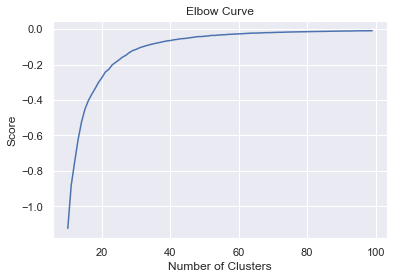

In [35]:
K_clusters = range(10,100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = gdf[['lat']]
X_axis = gdf[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [36]:
#on définit pour la suite le nombre de clusters qu'on souhaite
k =30

In [37]:
X=gdf.loc[:,['identifiant accident','lat','lon']]

In [38]:
kmeans = KMeans(n_clusters = k, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.sort_values(by = 'lat').head(10)

,identifiant accident,lat,lon,cluster_label
52055,201500034057,48.18055,2.72113,12
52054,201500034057,48.18055,2.72113,12
16275,200800007009,48.19000,2.59200,12
16276,200800007009,48.19000,2.59200,12
62005,201700040745,48.20000,2.33000,11
49800,201500009244,48.23190,2.68456,12
13046,200700041214,48.24400,2.90300,22
45061,201400009446,48.24400,2.98100,22
63789,201800004823,48.26309,2.90225,22
8551,200600052493,48.27400,2.86100,22


Text(0, 0.5, 'longitude')

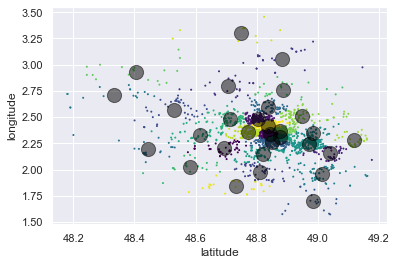

In [39]:
plt.scatter(x = X.lat, y = X.lon, s=1, c=labels,cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha =0.5, c='black')
plt.xlabel('latitude')
plt.ylabel('longitude')

In [41]:
model = cluster.AffinityPropagation()
k = X["cluster_label"].nunique()

Text(0.5, 1.0, 'Clustering (k=30)')

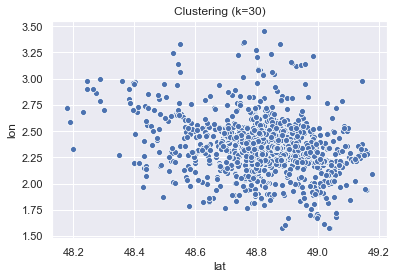

In [42]:
sns.scatterplot(x= X.lat, y=X.lon, 
                palette=sns.color_palette("bright", k),
                legend="brief").set_title('Clustering (k='+str(k)+')')

In [29]:
X = X[['identifiant accident','cluster_label']]
X.head(5)

,identifiant accident,cluster_label
61,200500001930,20
1142,200500024289,22
1143,200500024300,8
1149,200500024520,14
1152,200500024639,1


In [30]:
clustered_data = gdf.merge(X, left_on='identifiant accident', right_on='identifiant accident')
clustered_data.head(5)

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,...,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules,geometry,cluster_label
0,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,95042,49.064,2.328,non,...,NaN,NaN,Arrière,Sans changement de direction,200500001930B02,Cyclomoteur <50cm3,"Même sens, même file",1.0,POINT (2.32800 49.06400),20
1,200500024289,2005-04-10,04 - avril,6 - dimanche,9.0,78,78497,48.697,1.771,non,...,NaN,Véhicule,Avant,Déporté à gauche,200500024289A01,NaN,NaN,NaN,POINT (1.77100 48.69700),22
2,200500024300,2005-04-24,04 - avril,6 - dimanche,18.0,78,78062,48.850,1.890,oui,...,NaN,Véhicule,Avant,Sans changement de direction,200500024300B02,VL seul,Tournant à gauche,1.0,POINT (1.89000 48.85000),8
3,200500024520,2005-04-03,04 - avril,6 - dimanche,12.0,91,91105,48.575,2.166,oui,...,NaN,NaN,NaN,"Même sens, même file",200500024520B02,VL seul,"Même sens, même file",1.0,POINT (2.16600 48.57500),14
4,200500024639,2005-04-05,04 - avril,1 - mardi,11.0,78,78143,48.730,2.100,oui,...,NaN,Véhicule,Avant droit,Sans changement de direction,200500024639B02,VL seul,Traversant la chaussée,1.0,POINT (2.10000 48.73000),1


De toute évidence, cette méthode ne correspondait pas à ce que l'on cherchait. En effet, nous ne voulions pas garder toutes les données pour les mettre dans des clusters, mais plutôt trouver quelques endroits ou il y a des accidents très proches les uns des autres. Ainsi, la méthode DBSCAN nous a semblé plus pertinente

### Les débuts avec la méthode DBSCAN

Nous avons commencé par utiliser la méthode la plus habituelle pour déterminer epsilon. Nous nous sommes alors aperçues que notre epsilon a nous dépendait de critères spatiaux que nous pouvions chosiir (à partir de combien de mètre peut on dire que les accidents ne sont pas du à un même lieu accidentogène. 
Finalement, nous avons déterminé epsilon directement par une distance (en transformant les radians en km) dans le notebook final

In [43]:
X=gdf.loc[:,['lat','lon']]
#X
#gdf
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

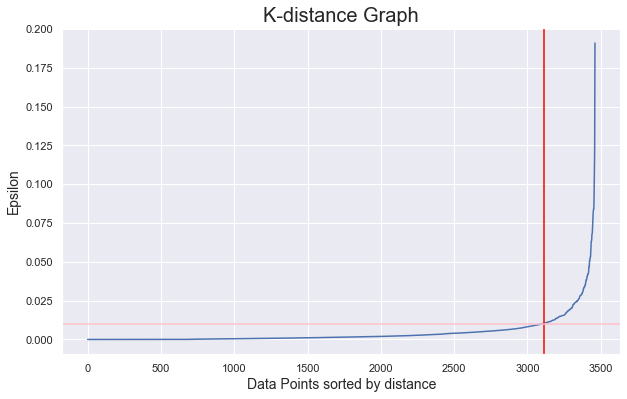

In [44]:
neigh = NearestNeighbors(n_neighbors=2) # à vérifier
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1] # On fit avec le training set donc le plus proche voisin est lui-même
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.axvline(x=(0.9)*3462, c ='red')
plt.axhline(y=0.01, c= 'pink')
plt.show()
#Comme nous l’avons vu précédemment nous allons choisir un ε de tel sorte que 90% des observations aient une distance au proche voisin inférieure à ε. 
#je fais 0.9*3600 données = 3200, on voit pour 3200 epsilon environ = 0.01
#Sauf que, nous on ne cherche pas le nombre de cluster optimal de cette façon, on préfère le faire de manière géographique